# Transfer Learning Classifier with Tensorflow and Keras
Create Databricks libraries for the following:
* tensorflow
* keras

In [2]:
import tensorflow
print (tensorflow.__version__)

from keras import backend as K

1.12.0
Using TensorFlow backend.

In [3]:
# Helper functions
import numpy as np

# Resize image
def resize_image(img, size):
    from PIL import Image, ImageOps 
    
    # Convert RGBA images to RGB
    if np.array(img).shape[2] == 4:
        img = img.convert('RGB')
        
    # resize the image
    img.thumbnail(size, Image.ANTIALIAS)
    newimg = Image.new("RGB", size, (255, 255, 255))
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
    
    return newimg


# iterate through folders, assembling feature, label, and classname data objects
def load_data (folder):
    
    import os
    from PIL import Image
    import matplotlib.pyplot as plt
    
    size = (200,200)

    c = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in dirs:
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                imgFile = os.path.join(root,d, f)
                img = Image.open(imgFile)
                img = np.array(resize_image(img, size))
                features.append(img)
                labels = np.append(labels, c)
            c = c + 1
    features = np.array(features)
    
    return features, labels, classnames

In [4]:
# Prepare the image data
features, labels, classnames = load_data('/dbfs/gear_images')
features.shape

Out[ 3 ]: (2122, 200, 200, 3)

In [5]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split


# split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)

#Format features
x_train = x_train.astype('float32')
x_train /= 255
x_test = x_test.astype('float32')
x_test /= 255

# Format labels
y_train = np_utils.to_categorical(y_train, len(classnames))
y_train = y_train.astype('float32')
y_test = np_utils.to_categorical(y_test, len(classnames))
y_test = y_test.astype('float32')

In [6]:
from keras import applications
#Load the base model, not including its final connected layer, and set the input shape to match our images
base_model = applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(features.shape[1], features.shape[2], features.shape[3]))

Downloading data from https://github.com/fchollet/deep-learning-models/releases/download/v0.7/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5

 8192/219055592 [..............................] - ETA: 2:53
 1335296/219055592 [..............................] - ETA: 9s 
 3801088/219055592 [..............................] - ETA: 6s
 7487488/219055592 [>.............................] - ETA: 4s
 13099008/219055592 [>.............................] - ETA: 3s
 17784832/219055592 [=>............................] - ETA: 2s
 19636224/219055592 [=>............................] - ETA: 3s
 22986752/219055592 [==>...........................] - ETA: 3s
 28942336/219055592 [==>...........................] - ETA: 2s
 34840576/219055592 [===>..........................] - ETA: 2s
 41558016/219055592 [====>.........................] - ETA: 2s
 47775744/219055592 [=====>........................] - ETA: 2s
 53420032/219055592 [======>.......................] - ETA: 1s
 56066048/219055592 [======>.......................] - ETA: 2s
 60989440/219055592 [=======>......................] - ETA: 1s
 64569344/219055592 [=======>......................] - ETA: 1s
 68534272/219055592 [========>.....................] - ETA: 1s
 71991296/219055592 [========>.....................] - ETA: 1s
 75718656/219055592 [=========>....................] - ETA: 1s
 81436672/219055592 [==========>...................] - ETA: 1s
 87367680/219055592 [==========>...................] - ETA: 1s
 89374720/219055592 [===========>..................] - ETA: 1s
 94707712/219055592 [===========>..................] - ETA: 1s
 99123200/219055592 [============>.................] - ETA: 1s
104972288/219055592 [=============>................] - ETA: 1s
109707264/219055592 [==============>...............] - ETA: 1s
113827840/219055592 [==============>...............] - ETA: 1s
116776960/219055592 [==============>...............] - ETA: 1s
122281984/219055592 [===============>..............] - ETA: 1s
128786432/219055592 [================>.............] - ETA: 1s
134864896/219055592 [=================>............] - ETA: 0s
139280384/219055592 [==================>...........] - ETA: 0s
144547840/219055592 [==================>...........] - ETA: 0s
149585920/219055592 [===================>..........] - ETA: 0s
154124288/219055592 [====================>.........] - ETA: 0s
157835264/219055592 [====================>.........] - ETA: 0s
160571392/219055592 [====================>.........] - ETA: 0s
164970496/219055592 [=====================>........] - ETA: 0s
168230912/219055592 [======================>.......] - ETA: 0s
174383104/219055592 [======================>.......] - ETA: 0s
180011008/219055592 [=======================>......] - ETA: 0s
185516032/219055592 [========================>.....] - ETA: 0s
191430656/219055592 [=========================>....] - ETA: 0s
195379200/219055592 [=========================>....] - ETA: 0s
201187328/219055592 [==========================>...] - ETA: 0s
207167488/219055592 [===========================>..] - ETA: 0s
213458944/219055592 [============================>.] - ETA: 0s
217800704/219055592 [============================>.] - ETA: 0s
218267648/219055592 [============================>.] - ETA: 0s
219062272/219055592 [==============================] - 3s 0us/step

In [7]:
# Train a CNN classifier
from keras import Model
from keras.layers import Flatten, Dense

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create layers for classification of our images
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classnames), activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

num_epochs = 10
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(x_test, y_test))

Train on 1485 samples, validate on 637 samples
Epoch 1/10

 32/1485 [..............................] - ETA: 8:01 - loss: 2.9768 - acc: 0.0000e+00
 64/1485 [>.............................] - ETA: 4:53 - loss: 5.9411 - acc: 0.1250 
 96/1485 [>.............................] - ETA: 4:03 - loss: 6.0842 - acc: 0.2188
 128/1485 [=>............................] - ETA: 3:24 - loss: 6.5047 - acc: 0.2500
 160/1485 [==>...........................] - ETA: 3:06 - loss: 6.6133 - acc: 0.2938
 192/1485 [==>...........................] - ETA: 2:43 - loss: 6.8953 - acc: 0.2708
 224/1485 [===>..........................] - ETA: 2:26 - loss: 7.2214 - acc: 0.2768
 256/1485 [====>.........................] - ETA: 2:13 - loss: 7.3512 - acc: 0.2852
 288/1485 [====>.........................] - ETA: 2:02 - loss: 7.3552 - acc: 0.3090
 320/1485 [=====>........................] - ETA: 1:53 - loss: 7.0827 - acc: 0.3312
 352/1485 [======>.......................] - ETA: 1:45 - loss: 6.8625 - acc: 0.3523
 384/1485 [======>.......................] - ETA: 1:39 - loss: 6.6199 - acc: 0.3672
 416/1485 [=======>......................] - ETA: 1:33 - loss: 6.3608 - acc: 0.3870
 448/1485 [========>.....................] - ETA: 1:27 - loss: 6.3107 - acc: 0.3772
 480/1485 [========>.....................] - ETA: 1:23 - loss: 6.1163 - acc: 0.3937
 512/1485 [=========>....................] - ETA: 1:18 - loss: 5.9745 - acc: 0.4121
 544/1485 [=========>....................] - ETA: 1:14 - loss: 5.6615 - acc: 0.4412
 576/1485 [==========>...................] - ETA: 1:10 - loss: 5.5480 - acc: 0.4583
 608/1485 [===========>..................] - ETA: 1:07 - loss: 5.5380 - acc: 0.4671
 640/1485 [===========>..................] - ETA: 1:03 - loss: 5.3843 - acc: 0.4859
 672/1485 [============>.................] - ETA: 1:00 - loss: 5.2710 - acc: 0.5000
 704/1485 [=============>................] - ETA: 57s - loss: 5.1035 - acc: 0.5185 
 736/1485 [=============>................] - ETA: 54s - loss: 5.0402 - acc: 0.5258
 768/1485 [==============>...............] - ETA: 51s - loss: 4.9237 - acc: 0.5378
 800/1485 [===============>..............] - ETA: 48s - loss: 4.8693 - acc: 0.5475
 832/1485 [===============>..............] - ETA: 45s - loss: 4.7756 - acc: 0.5553
 864/1485 [================>.............] - ETA: 43s - loss: 4.6788 - acc: 0.5648
 896/1485 [=================>............] - ETA: 40s - loss: 4.5987 - acc: 0.5714
 928/1485 [=================>............] - ETA: 38s - loss: 4.5530 - acc: 0.5744
 960/1485 [==================>...........] - ETA: 35s - loss: 4.5090 - acc: 0.5813
 992/1485 [===================>..........] - ETA: 33s - loss: 4.4462 - acc: 0.5867
1024/1485 [===================>..........] - ETA: 30s - loss: 4.4036 - acc: 0.5889
1056/1485 [====================>.........] - ETA: 28s - loss: 4.3264 - acc: 0.5938
1088/1485 [====================>.........] - ETA: 26s - loss: 4.2794 - acc: 0.5983
1120/1485 [=====================>........] - ETA: 24s - loss: 4.2111 - acc: 0.6009
1152/1485 [======================>.......] - ETA: 21s - loss: 4.1511 - acc: 0.6050
1184/1485 [======================>.......] - ETA: 19s - loss: 4.0811 - acc: 0.6132
1216/1485 [=======================>......] - ETA: 17s - loss: 4.0025 - acc: 0.6209
1248/1485 [========================>.....] - ETA: 15s - loss: 4.0195 - acc: 0.6210
1280/1485 [========================>.....] - ETA: 13s - loss: 3.9696 - acc: 0.6273
1312/1485 [=========================>....] - ETA: 11s - loss: 3.8980 - acc: 0.6349
1344/1485 [==========================>...] - ETA: 9s - loss: 3.8292 - acc: 0.6421 
1376/1485 [==========================>...] - ETA: 6s - loss: 3.8186 - acc: 0.6446
1408/1485 [===========================>..] - ETA: 4s - loss: 3.8050 - acc: 0.6470
1440/1485 [============================>.] - ETA: 2s - loss: 3.7448 - acc: 0.6528
1472/1485 [============================>.] - ETA: 0s - loss: 3.7359 - acc: 0.6549
1485/1485 [==============================] - 131s 88ms/step - loss: 3.7365 - acc: 0.6545 - val_loss: 11

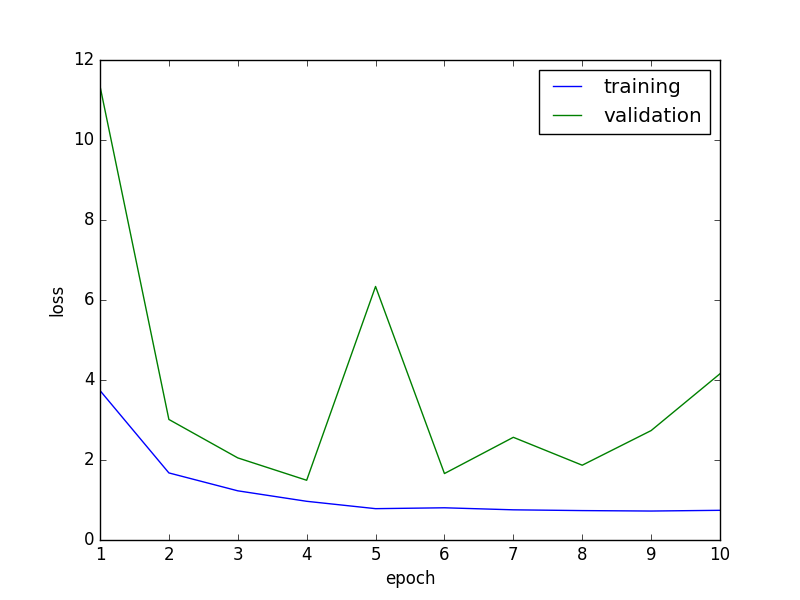

In [8]:
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
fig = plt.figure(figsize=(8, 6))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()
display(fig)

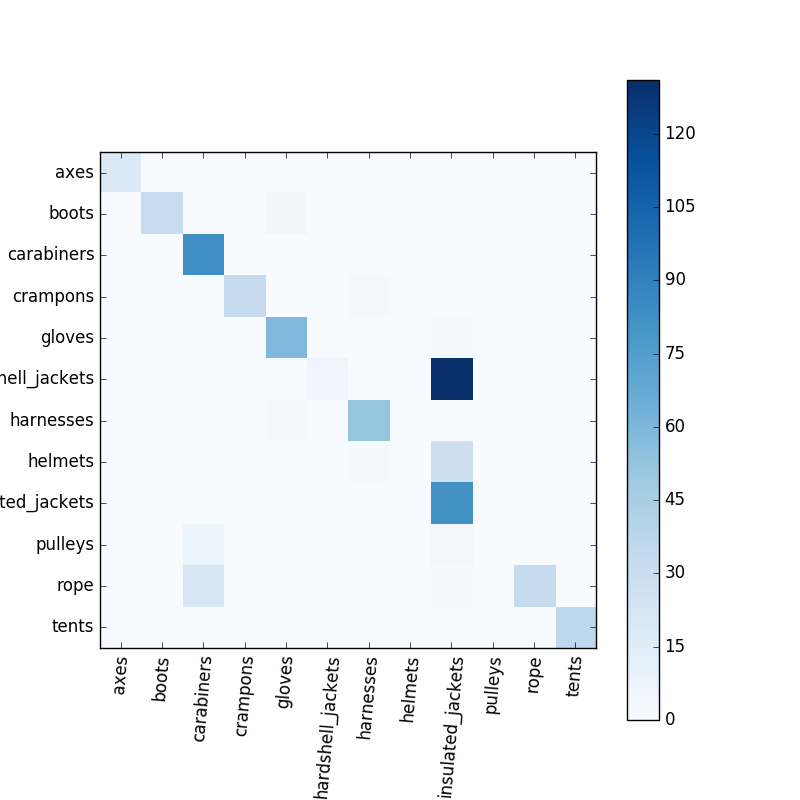

In [9]:
#Keras doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


class_probabilities = model.predict(x_test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
fig = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()
display(fig)

In [10]:
def predict_image(classifier, img):
    import numpy as np
    
    # Flatten the image data to correct feature format
    imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255

    # Use the classifier to predict the class
    predicted_class = classifier.predict(imgfeatures)
    i = np.argmax(predicted_class, axis=1)
    return i

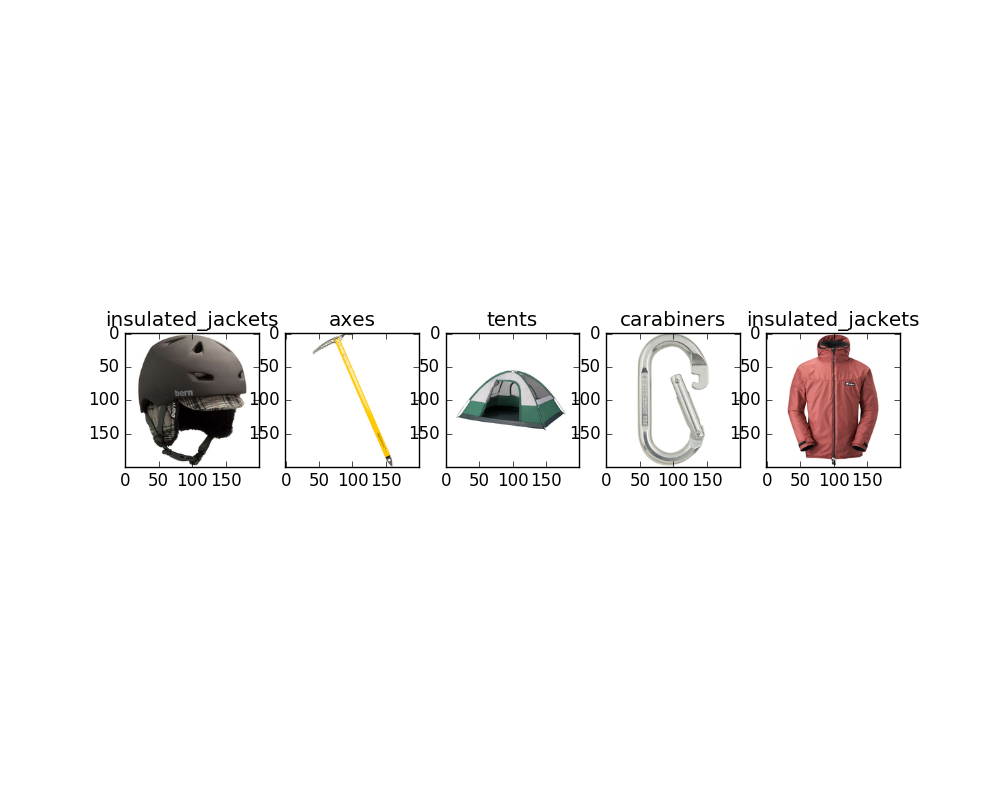

In [11]:
# Predict class for new data
from PIL import Image, ImageOps
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

image_urls = []
image_urls.append('https://i.stack.imgur.com/5I4Rx.jpg')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

size = (200,200)

fig = plt.figure(figsize=(10, 8))

# Get the images and show the predicted classes
for url_idx in range(len(image_urls)):
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    #pre-process the image so it matches the training set
    img = np.array(resize_image(img, size))
    class_idx = predict_image(model, img)
    class_name = classnames[class_idx[0]]
    a=fig.add_subplot(1,len(image_urls),url_idx+1)
    imgplot = plt.imshow(img)
    a.set_title(class_name)
    
display(fig)